In [14]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint, box
import fiona
from shapely.ops import nearest_points
import pickle

In [2]:
xmin, xmax, ymin, ymax = -382700, -374781.9, -734075.1, -721770.2

In [3]:
!pwd

/Users/home/whitefar/DATA/Jupyter/REMA


In [4]:
# x_interpd = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_x.npy')
# y_interpd = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_y.npy')
# it_interpd = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_ice_thickn.npy')
# ib_interpd = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_icebase.npy')

In [5]:
#load REMA
nid1 = 159202
nid2 = 131226
df = gpd.read_file('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/REMA_Strip_Index_Rel1/REMA_Strip_Index_Rel1.shp')

In [6]:
path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-131226_diff.tif"
f = df.loc[nid1].acquisitio
t =df.loc[nid2].acquisitio

In [7]:
df.loc[nid2].fileurl

'http://data.pgc.umn.edu/elev/dem/setsm/REMA/geocell/v1.0/2m/s83w153/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0.tar.gz'

In [8]:
duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
with rio.open(path) as image:
    im = image.read(1)
    im = im / duration
#     im[im==-9999] = np.nan
    extent_REMAdiff = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    left = image.bounds[0]
    bottom = image.bounds[1]
    right = image.bounds[2]    
    top = image.bounds[3]
    

In [9]:
#load REMA demfocussing on
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)
    
x = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')
y = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')

x_i = np.argwhere((x>xmin) & (x< xmax)).flatten()[0]
x_j = np.argwhere((x>xmin) & (x< xmax)).flatten()[-1]
y_i = np.argwhere((y>ymin) & (y< ymax)).flatten()[0]
y_j = np.argwhere((y>ymin) & (y< ymax)).flatten()[-1]

x_c = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')[x_i:x_j]
y_c = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')[y_i:y_j]

xv_REMA, yv_REMA = np.meshgrid(x_c, y_c)

im_REMA_d = im_REMA[y_i:y_j,x_i:x_j]
im_REMA_d[im_REMA_d==-99.99] = np.nan
im_REMA_c = im_REMA_d

In [10]:
im_REMA[im_REMA!=-9999.0].mean()

67.36358

In [11]:
# im_REMAdiff[np.abs(im_REMAdiff)>50]=np.nan

In [12]:
# Load ice base interpolated from radar results
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_gridded_'

xv = np.load(direc + 'x_grid' +'.npy')
yv = np.load(direc + 'y_grid' +'.npy')
thickness_interpolated = np.load(direc +'ice_thickn.npy')
extent_l2l = np.load(direc +'extent.npy')
ice_base = np.load(direc +'ice_base.npy')
ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)

In [15]:
with open('/Users/home/whitefar/DATA/global_corrections.pkl',"rb") as f2:
    correct = pickle.load(f2)
geoid_correction = correct['geoid_correction']
res_correction = correct['res_correction']
apres_firn = correct['apres_firn']

In [16]:
#smooth REMA dem for contours
im_REMA_c_smoo = sp.ndimage.gaussian_filter(im_REMA_c, sigma=20, order=0)
del im_REMA_d,im_REMA_c

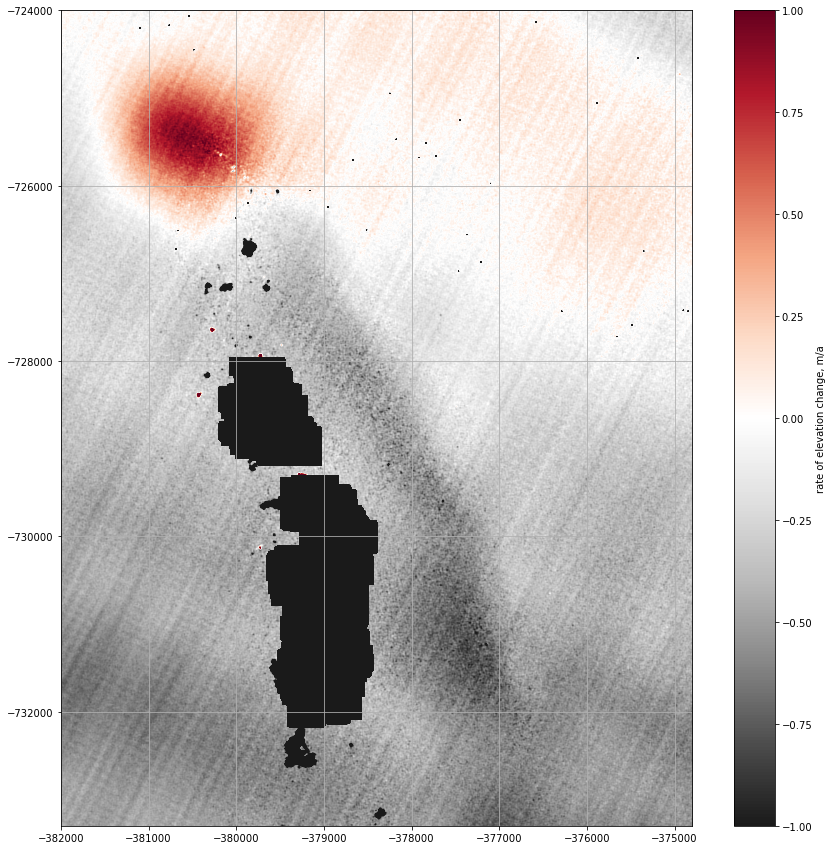

In [17]:
plt.figure(figsize=(15,15))
GyRd = plt.cm.get_cmap('RdGy').reversed()
plt.imshow(im,extent=extent_REMAdiff, vmin=-1,vmax=1,cmap=GyRd)
cb = plt.colorbar()
cb.set_label('rate of elevation change, m/a')
plt.xlim([-382000, -374800])
plt.ylim([-733300,-724000])
plt.grid()
plt.show()

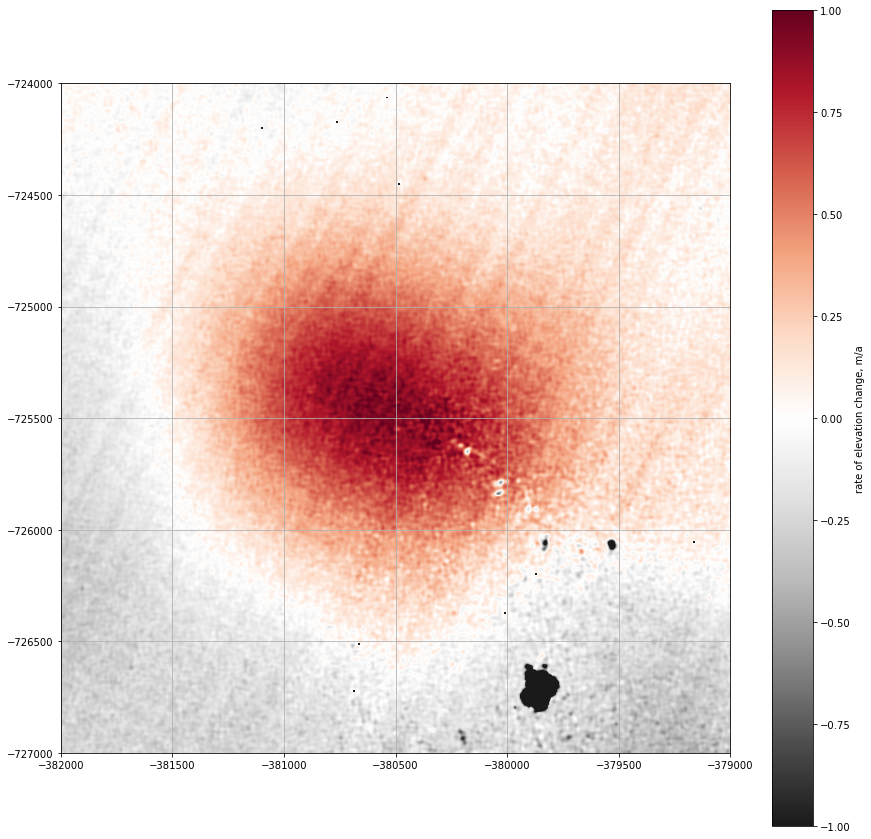

In [19]:
plt.figure(figsize=(15,15))
GyRd = plt.cm.get_cmap('RdGy').reversed()
plt.imshow(im,extent=extent_REMAdiff, vmin=-1,vmax=1,cmap=GyRd)
cb = plt.colorbar()
cb.set_label('rate of elevation change, m/a')
plt.xlim([-382000, -379000])
plt.ylim([-727000,-724000])
plt.grid()
plt.show()

# Variance over stable terrain

In [20]:
grounded = np.load('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable.npy')
xv = np.load('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_xv.npy')
yv = np.load('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_yv.npy')
grounded_nonan = np.load('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_nonan.npy')

In [21]:
#there are two clusters of grounded points, north and south of 726000
grounded_points = np.array([xv[grounded==1].T,yv[grounded==1].T])

In [22]:
grounded_points_N = grounded_points[:, grounded_points[1,:]>-725700]
grounded_points_S = grounded_points[:, grounded_points[1,:]<-726500]

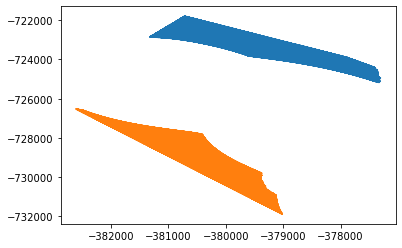

In [23]:
plt.plot(grounded_points_N[0,:],grounded_points_N[1,:])
plt.plot(grounded_points_S[0,:],grounded_points_S[1,:])

In [24]:
N_hull = MultiPoint( [(x,y) for x,y in zip(grounded_points_N[0,::2],grounded_points_N[1,::2])]).convex_hull
S_hull = MultiPoint( [(x,y) for x,y in zip(grounded_points_S[0,::2],grounded_points_S[1,::2])]).convex_hull

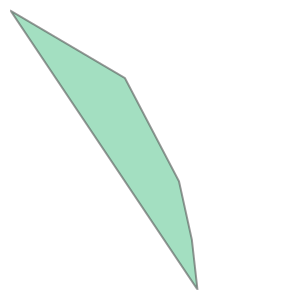

In [25]:
S_hull

In [26]:
with open('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/shapefiles/bullseye.pkl', "rb") as poly_file:
    bullseye = pickle.load(poly_file)

In [27]:
gdf_N = gpd.GeoDataFrame(geometry=[N_hull])
gdf_S = gpd.GeoDataFrame(geometry=[S_hull])
gdf_bullseye = gpd.GeoDataFrame(geometry=[bullseye])
gdf_N

,geometry
0,"POLYGON ((-377332.000 -725164.000, -377378.000..."


In [28]:
# gdf_N.to_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_shapefile_N.shp')
# gdf_S.to_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_shapefile_S.shp')
# gdf_bullseye.to_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/bullseye.shp')

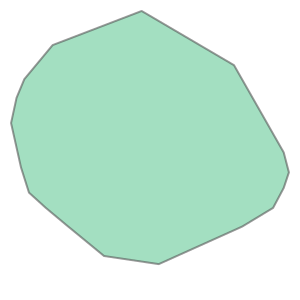

In [29]:
bullseye

QGIS DID 
```
gdalwarp -overwrite -s_srs EPSG:3031 -t_srs EPSG:3031 -of GTiff -tr 2.0 -2.0 -tap -cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_shapefile.shp -cl stable_shapefile -crop_to_cutline /Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-131226_diff.tif /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable.tif
```

```
gdalwarp -overwrite -s_srs EPSG:3031 -t_srs EPSG:3031 -of GTiff -cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_shapefile_N.shp -cl stable_shapefile_N -crop_to_cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable.tif /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable_N.tif
```

```
gdalwarp -overwrite -s_srs EPSG:3031 -t_srs EPSG:3031 -of GTiff -cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_shapefile_S.shp -cl stable_shapefile_S -crop_to_cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable.tif /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable_S.tif
```

```
gdalwarp -overwrite -s_srs EPSG:3031 -t_srs EPSG:3031 -of GTiff -cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/bullseye.shp -cl bullseye -crop_to_cutline /Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-131226_diff.tif /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_bullseye.tif
```

In [35]:
stable_diff = {}
stable_diff_extent = {}
for tif in ['diff_masked_to_stable_N','diff_masked_to_stable_S','diff_masked_to_bullseye','diff_masked_to_handrawn']:

    with rio.open(f'/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/{tif}.tif') as image:
        stable_diff[tif] =  image.read(1)
        stable_diff_extent[tif] = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
#     with rio.open('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable_S.tif') as image:
#         stable_diff_S = image.read(1)
#         stable_diff_extent_S = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
#     with rio.open('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable_N.tif') as image:
#         stable_diff_N = image.read(1)
#         stable_diff_extent_N = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
#     with rio.open('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_bullseye.tif') as image:
#         stable_diff_bullseye = image.read(1)
#         stable_diff_extent_bullseye = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]

In [36]:
stable_diff.keys()

dict_keys(['diff_masked_to_stable_N', 'diff_masked_to_stable_S', 'diff_masked_to_bullseye', 'diff_masked_to_handrawn'])

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


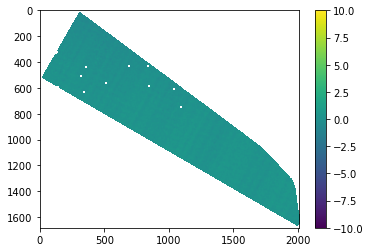

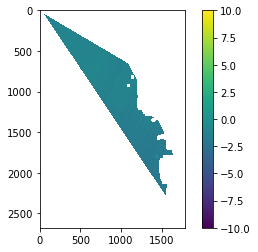

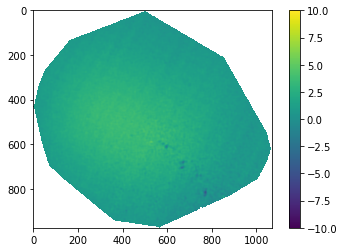

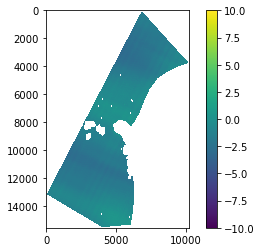

In [37]:
for k in stable_diff.keys():
    stable_diff[k][stable_diff[k]<-10] = np.nan
    stable_diff[k][stable_diff[k]>10] = np.nan
    plt.figure()
    plt.imshow(stable_diff[k],vmin=-10,vmax=10)
    plt.colorbar()

In [45]:
stable_diff.keys()

dict_keys(['diff_masked_to_stable_N', 'diff_masked_to_stable_S', 'diff_masked_to_bullseye', 'diff_masked_to_handrawn'])

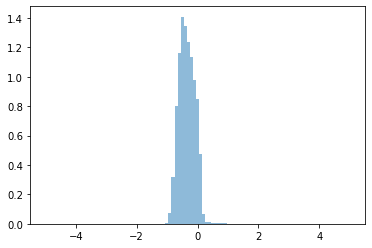

In [44]:
n, bins, patches = plt.hist(im[im>-10], 
                              bins=np.linspace(-5,5,100), 
                              density=True,alpha=0.5,
#                                 color=color[i],
#                             label=labels[i]
                           )

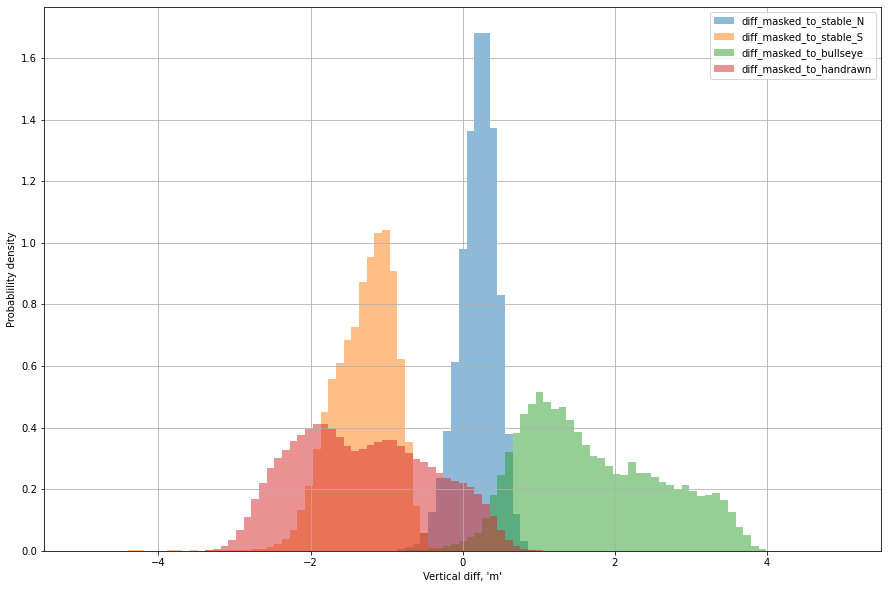

In [49]:
plt.figure(figsize=(15,10))
labels=stable_diff.keys()
color=['blue','orange','green']
for k in list(stable_diff.keys()):
    n, bins, patches = plt.hist(stable_diff[k][::10][~np.isnan(stable_diff[k][::10])], 
                                  bins=np.linspace(-5,5,100), 
                                  density=True,alpha=0.5,
#                                 color=color[i],
                                label=k
                               )

#     plt.vlines(np.mean(stable_diff[i]),0,1.7,color='black')
#     plt.vlines(np.mean(stable_diff[i])-np.std(stable_diff[i]),0,1.7,color='red')
#     plt.vlines(np.mean(stable_diff[i])+np.std(stable_diff[i]),0,1.7,color='red')

# n, bins, patches = plt.hist(im[im>-10], 
#                               bins=np.linspace(-5,5,100), 
#                               density=True,alpha=0.5,
# #                                 color=color[i],
#                             label='Full difference image'
#                            )
plt.legend()
plt.xlabel("Vertical diff, 'm'")
plt.ylabel("Probablility density")
plt.grid()

In [ ]:
n, bins, patches = plt.hist(stable_diff[k][::10], 
                                  bins=np.linspace(-5,5,100), 
                                  density=True,alpha=0.5,
#                                 color=color[i],
                                label=k
                               )

In [167]:
for a in stable_diff:
    print(np.mean(a),np.std(a))
#     print()

0.20468901 0.32086852
-1.4299912 1.9588782
1.698211 0.92154646


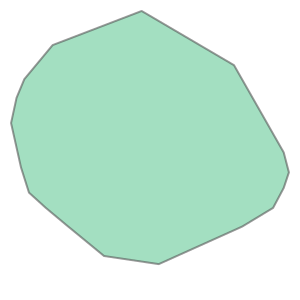

In [235]:
N_hull.exterior.coords.xy[0]

In [198]:
extent_REMApic = extent_REMAdiff.copy()

In [227]:
yticks = (np.linspace(-734000,-722000,4)/1000).astype(int)
xticks = (np.linspace(-382000,-376000,4)/1000).astype(int)

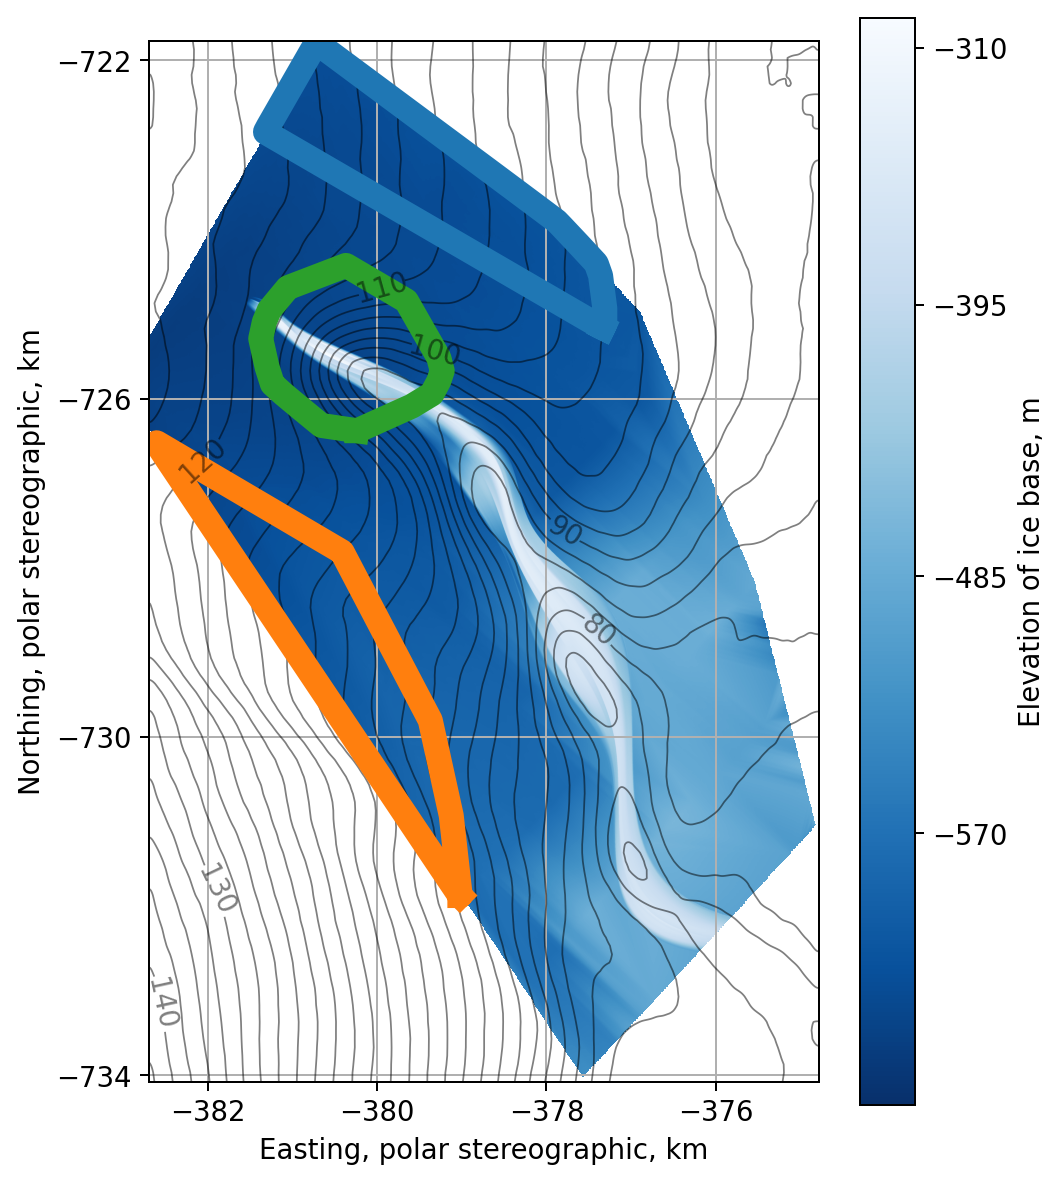

In [244]:
plt.figure( dpi=180,figsize=(6,8))

plt.rcParams.update({'font.size': 11})


# #C base with surface contours
samp = 50
CS =  plt.contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp]+geoid_correction,
                      30,vmin=15+geoid_correction,vmax=90+geoid_correction, 
#                   cmap='BrBG',
                  colors='black',
                  alpha=0.5,linewidths=0.7)
plt.clabel(CS,CS.levels[0::4], inline=1,  fmt='%i')

for shape in [N_hull,S_hull,bullseye]:
    plt.plot(np.array(shape.exterior.coords.xy[0])/1000,np.array(shape.exterior.coords.xy[1])/1000,linewidth=5)
    
plt.imshow(ice_base+geoid_correction+res_correction,extent=np.array(extent_l2l)/1000,cmap='Blues_r',vmin=-700+geoid_correction+res_correction,vmax=-340+geoid_correction+res_correction)
cb3 = plt.colorbar()
cb3.set_label('Elevation of ice base, m')
cb3.set_ticks(np.round(np.linspace(-350+geoid_correction + res_correction,-700+geoid_correction + res_correction,5)/5)*5)

# plt.plot(gpr.x/1000,gpr.y/1000,'r.',label='radar profiles',markersize=0.05)

plt.xlim([xmin/1000,xmax/1000])
plt.ylim([ymin/1000,ymax/1000])
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('Easting, polar stereographic, km')
plt.ylabel('Northing, polar stereographic, km')
plt.grid()


In [ ]:
plt.imshow(im, vmin=-1,vmax=1,cmap=GyRd)


In [185]:
slope = np.sqrt(np.diff(im,axis=0)[:,1:]**2+np.diff(im,axis=1)[1:,:]**2)

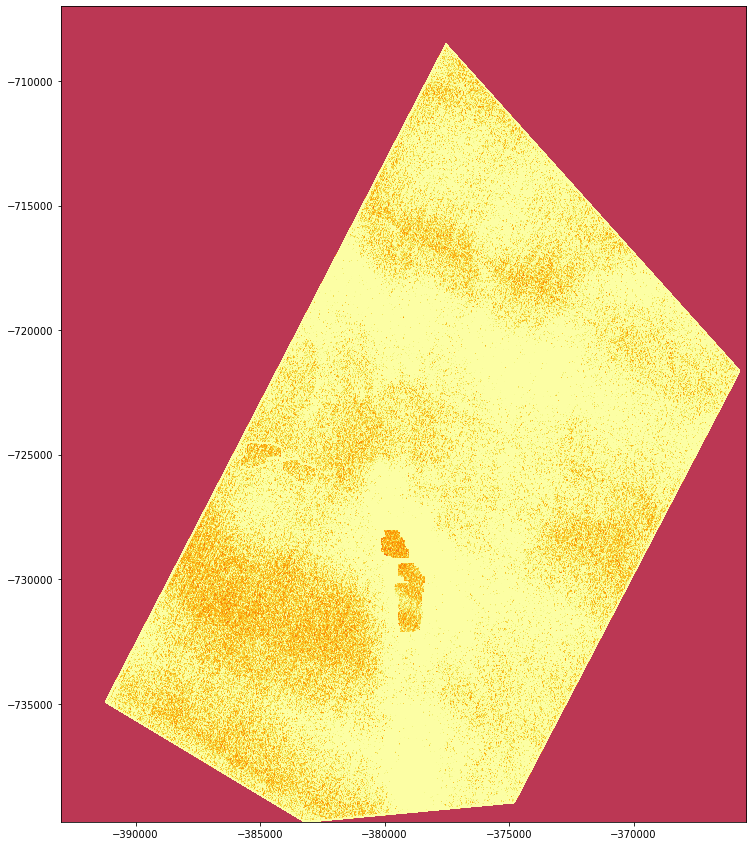

In [210]:
plt.figure(figsize=(15,15))
plt.imshow(slope,extent=extent_REMAdiff,vmin=-0.01,vmax=0.01,cmap='inferno')
plt.xlim([-393000,extent_REMAdiff[1]])
plt.ylim([extent_REMAdiff[2],-707000])
plt.show()

In [263]:
bbox = box(xmin, xmax, ymin, ymax )
#groundingline
groundingline_path = glob.glob(f"/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Miscellaneous/ScrippsGroundingLine/*.shp")[0]
groundingline =  gpd.read_file(groundingline_path)
# groundingline_path

groundingline = groundingline[groundingline.geometry.intersects(bbox)].copy()

coast = groundingline.geometry.iloc[0].exterior.coords[:]

gl = np.array([[x,y] for x,y in coast ])

gl = gl[(gl[:,0]< -360000) & (gl[:,0]> -400000) & (gl[:,1] > -760000) & (gl[:,1] <  -700000)].copy()
# gl = gl[(gl[:,0]< xmax) & (gl[:,0]> xmin) & (gl[:,1] > ymin) & (gl[:,1] <  ymax)].copy()

In [265]:
groundingline_path

'/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Miscellaneous/ScrippsGroundingLine/scripps_antarctica_polygons_v1.shp'

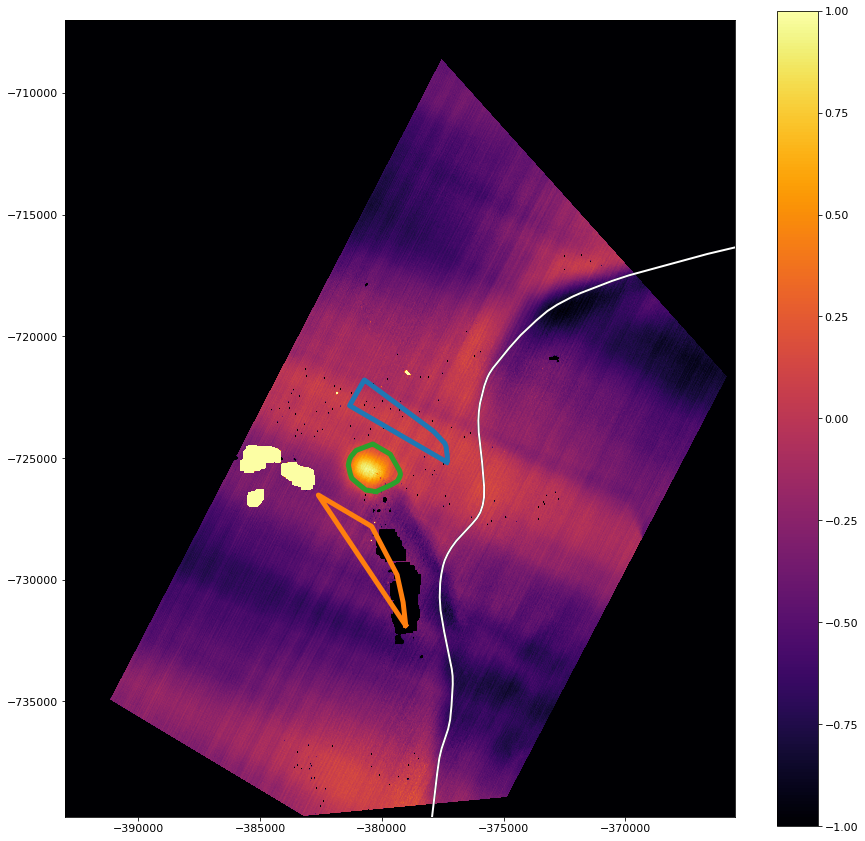

In [264]:
plt.figure(figsize=(15,15))
plt.imshow(im,extent=extent_REMAdiff,vmin=-1,vmax=1,cmap='inferno')
for shape in [N_hull,S_hull,bullseye]:
    plt.plot(np.array(shape.exterior.coords.xy[0]),np.array(shape.exterior.coords.xy[1]),linewidth=5)

plt.plot(gl[:,0],gl[:,1],'k-',linewidth=2.2)
plt.plot(gl[:,0],gl[:,1],'w-',
#          label='Grounding Line',
         linewidth=2)
plt.xlim([-393000,extent_REMAdiff[1]])
plt.ylim([extent_REMAdiff[2],-707000])
plt.colorbar()
plt.show()

# full grounded area

```
gdalwarp -overwrite -s_srs EPSG:3031 -t_srs EPSG:3031 -of GTiff -cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/handdrawn_stablemask.shp -cl handdrawn_stablemask -crop_to_cutline /Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-131226_diff.tif /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_handrawn.tif
```

In [ ]:
plt.figure(figsize=(15,10))
labels=['Northern stable area','Southern stable area','Area of lowering','handdrawn']
color=['blue','orange','green']
for i in range(4):
    n, bins, patches = plt.hist(stable_diff[i], 
                                  bins=np.linspace(-5,5,100), 
                                  density=True,alpha=0.5,
#                                 color=color[i],
                                label=labels[i]
                               )

#     plt.vlines(np.mean(stable_diff[i]),0,1.7,color='black')
#     plt.vlines(np.mean(stable_diff[i])-np.std(stable_diff[i]),0,1.7,color='red')
#     plt.vlines(np.mean(stable_diff[i])+np.std(stable_diff[i]),0,1.7,color='red')
n, bins, patches = plt.hist(im[im>-10], 
                              bins=np.linspace(-5,5,100), 
                              density=True,alpha=0.5,
#                                 color=color[i],
                            label='Full difference image'
                           )
plt.legend()
plt.xlabel("Vertical diff, 'm'")
plt.ylabel("Probablility density")
plt.grid()

In [51]:
list(stable_diff.keys())

['diff_masked_to_stable_N',
 'diff_masked_to_stable_S',
 'diff_masked_to_bullseye',
 'diff_masked_to_handrawn']

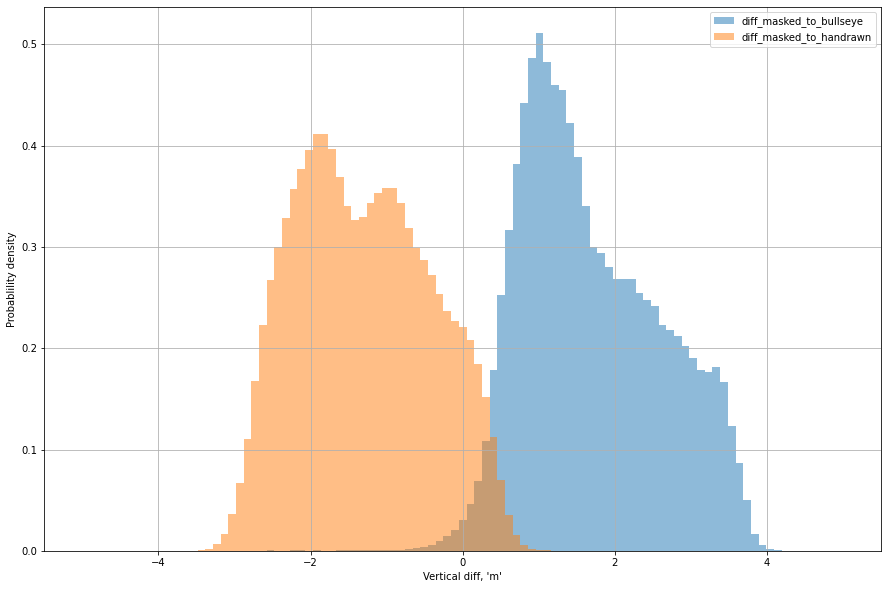

In [53]:
plt.figure(figsize=(15,10))
labels=stable_diff.keys()
color=['blue','orange','green']
for k in ['diff_masked_to_bullseye', 'diff_masked_to_handrawn']:
    n, bins, patches = plt.hist(stable_diff[k][~np.isnan(stable_diff[k])], 
                                  bins=np.linspace(-5,5,100), 
                                  density=True,alpha=0.5,
#                                 color=color[i],
                                label=k
                               )

#     plt.vlines(np.mean(stable_diff[i]),0,1.7,color='black')
#     plt.vlines(np.mean(stable_diff[i])-np.std(stable_diff[i]),0,1.7,color='red')
#     plt.vlines(np.mean(stable_diff[i])+np.std(stable_diff[i]),0,1.7,color='red')

# n, bins, patches = plt.hist(im[im>-10], 
#                               bins=np.linspace(-5,5,100), 
#                               density=True,alpha=0.5,
# #                                 color=color[i],
#                             label='Full difference image'
#                            )
plt.legend()
plt.xlabel("Vertical diff, 'm'")
plt.ylabel("Probablility density")
plt.grid()

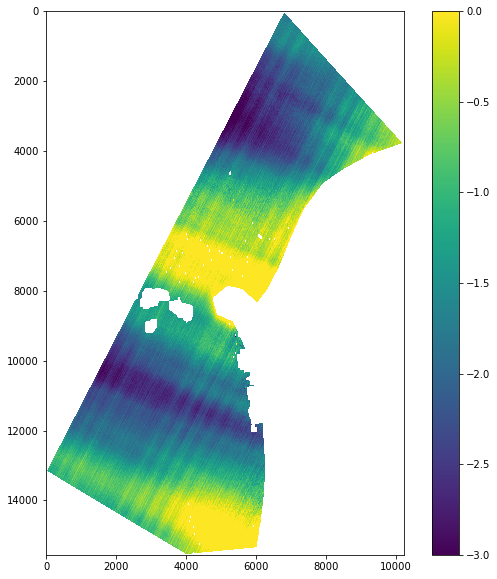

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(stable_diff['diff_masked_to_handrawn'],vmin =-3,vmax=0)
plt.colorbar()
plt.show()

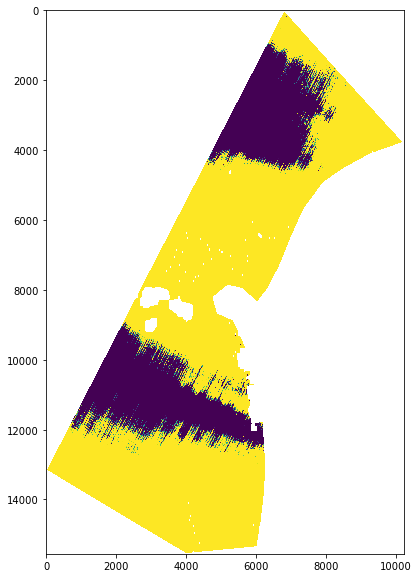

In [58]:
plt.figure(figsize=(10,10))
plt.imshow(stable_diff['diff_masked_to_handrawn'],vmin =-2,vmax=-1.9)
plt.show()

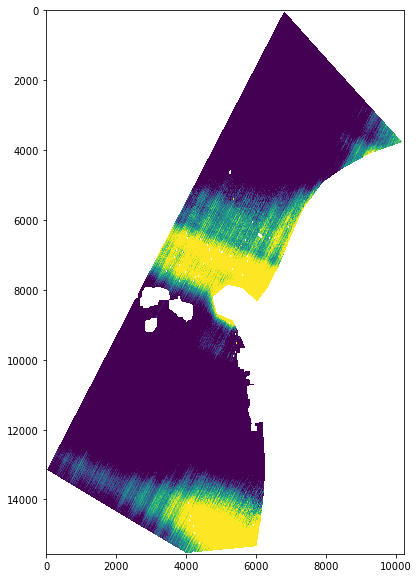

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(stable_diff['diff_masked_to_handrawn'],vmin =-1,vmax=0)
plt.show()

In [63]:
k='diff_masked_to_handrawn'
2*np.std(stable_diff[k][~np.isnan(stable_diff[k])])

1.778450608253479

In [64]:
np.mean(stable_diff[k][~np.isnan(stable_diff[k])])

-1.3019706

In [65]:
np.std(stable_diff[k][~np.isnan(stable_diff[k])])

0.8892253

In [67]:
for k in ['diff_masked_to_bullseye', 'diff_masked_to_handrawn']:
    print(k)
    print(np.mean(stable_diff[k][~np.isnan(stable_diff[k])])+np.std(stable_diff[k][~np.isnan(stable_diff[k])]),
      np.mean(stable_diff[k][~np.isnan(stable_diff[k])])-np.std(stable_diff[k][~np.isnan(stable_diff[k])]))
    

diff_masked_to_bullseye
2.6197574 0.7766645
diff_masked_to_handrawn
-0.4127453 -2.191196


In [68]:
for k in ['diff_masked_to_bullseye', 'diff_masked_to_handrawn']:
    print(k)
    print(np.mean(stable_diff[k][~np.isnan(stable_diff[k])]),
      np.std(stable_diff[k][~np.isnan(stable_diff[k])]))

diff_masked_to_bullseye
1.698211 0.92154646
diff_masked_to_handrawn
-1.3019706 0.8892253
